In [1]:
import collections
from pyteomics import fasta, parser

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# silence warnings
import warnings

warnings.filterwarnings("ignore")

/fs/home/rlopez/miniconda/dev/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
_MIN_SEQ_LENGTH = 8
_MAX_SEQ_LENGTH = 50


def get_digested_peptide_list(filepath, missed_cleavages=0):
    """Get the digested peptide list from a fasta file.
    Maps Isoleucine to Leucine.
    Removes peptides that are shorter than 8 or longer than 50 amino acids.

    Args:
        filepath (str): The path to the fasta file.
        missed_cleavages (int): The number of missed cleavages.

    Returns:
        unique_peptides (set): The set of unique peptides.
        protein_peptide_map (dict): The dictionary of protein to peptides.

    """
    unique_peptides = set()
    protein_peptide_map = {}
    protein_id_seq_map = {}
    with open(filepath, mode="rt") as fasta_file:
        print(f"Reading proteins from {filepath}...")
        for i, f in enumerate(fasta.FASTA(fasta_file)):
            description, sequence = f
            protein_id = description
            protein_id_seq_map[protein_id] = sequence
            cleaved_peptides = parser.cleave(
                sequence, "([KR])", missed_cleavages=missed_cleavages
            )
            clean_peptides = []
            protein_start = sequence[:_MIN_SEQ_LENGTH]
            for k, pep in enumerate(cleaved_peptides):
                if protein_start == pep[:_MIN_SEQ_LENGTH]:
                    clean_peptides.append(pep[1:].replace("I", "L"))
                if len(pep) >= _MIN_SEQ_LENGTH and len(pep) <= _MAX_SEQ_LENGTH:
                    clean_peptides.append(pep.replace("I", "L"))
            protein_peptide_map[protein_id] = clean_peptides
            unique_peptides.update(clean_peptides)
    print(
        f"Done, {len(unique_peptides)} sequences obtained from ",
        f"{len(protein_peptide_map)} protein isoforms corresponding to "
        f'{len(np.unique([p.split(" ")[0] for p in protein_peptide_map.keys()]))} genes',
    )
    peptides = [{"sequence": i} for i in unique_peptides]
    return unique_peptides, protein_peptide_map

In [3]:
peptides_targets, protein_peptide_map_targets = get_digested_peptide_list(
    "../data/benchmark_results/isb_18/fasta/targets_20130710-ISB18-extended.fasta"
)
peptides_contaminants, protein_peptide_map_contaminants = get_digested_peptide_list(
    "../data/benchmark_results/isb_18/fasta/contaminants.fasta"
)
peptides_entrapment, protein_peptide_map_entrapment = get_digested_peptide_list(
    "../data/benchmark_results/isb_18/fasta/entrapment_UP000008311_3988.fasta"
)

Reading proteins from ../data/benchmark_results/isb_18/fasta/targets_20130710-ISB18-extended.fasta...
Done, 750 sequences obtained from  48 protein isoforms corresponding to 48 genes
Reading proteins from ../data/benchmark_results/isb_18/fasta/contaminants.fasta...
Done, 5015 sequences obtained from  246 protein isoforms corresponding to 246 genes
Reading proteins from ../data/benchmark_results/isb_18/fasta/entrapment_UP000008311_3988.fasta...
Done, 474279 sequences obtained from  31219 protein isoforms corresponding to 31219 genes


In [4]:
print(f"Number of unique peptides in entrapment: {len(peptides_entrapment)}")
print(
    f"n targets: {len(peptides_targets)}, "
    f"also entrapment: {len(np.intersect1d(list(peptides_targets), list(peptides_entrapment)))}"
)

print(
    f"n contaminants: {len(peptides_contaminants)}, "
    f"also entrapment: {len(np.intersect1d(list(peptides_contaminants), list(peptides_entrapment)))}"
)

entrapment_only = peptides_entrapment - peptides_targets - peptides_contaminants

Number of unique peptides in entrapment: 474279
n targets: 750, also entrapment: 11
n contaminants: 5015, also entrapment: 2


In [5]:
def label_entrapment(df, pep_column, exp_name, min_seq_len=_MIN_SEQ_LENGTH):
    df = df[df[pep_column].str.len() >= min_seq_len].copy()
    df[pep_column] = df[pep_column].str.replace("I", "L")
    df["in_entrapment"] = df[pep_column].apply(lambda x: x in entrapment_only)
    df["in_targets_contaminants"] = df[pep_column].apply(
        lambda x: x in peptides_targets or x in peptides_contaminants
    )
    df["in_both"] = df["in_entrapment"] & df["in_targets_contaminants"]
    df["in_neither"] = ~df["in_entrapment"] & ~df["in_targets_contaminants"]
    # FP
    if pep_column == "Peptide":
        df["is_decoy"] = df["Protein ID"].str.contains("rev_")

    print(f"Total number of peptides: {len(df.query('~is_decoy'))} in {exp_name}")
    print(f'Number of entrapment peptides: {df["in_entrapment"].sum()}')
    print(f'Number of non-entrapment peptides: {df["in_targets_contaminants"].sum()}')
    print(
        f'In both: {df["in_both"].sum()}, in neither: {df.query("~is_decoy")["in_neither"].sum()}'
    )
    print(
        f'Percent FDP: {(df["in_entrapment"].sum() / df["in_targets_contaminants"].sum()) * 100:.2f}%'
    )

    return df

In [6]:
# Fix random seed
np.random.seed(42)


def compute_qs(examples):
    """Compute the q-values for a list of examples.


    Args:
        examples (list): A list of booleans indicating whether the example is an error
        (decoy, not in synthesized set), sorted by decreasing score.
    """
    fdrs = []
    true_positive = 0
    false_positive = 0
    for example in examples:
        if not example:
            true_positive += 1
        else:
            false_positive += 1

        if false_positive > 0 and true_positive == 0:
            fdrs.append(1.0)
        else:
            fdrs.append(false_positive / true_positive)

    def cummin(xs):
        ys = [xs[0]]
        for x in xs[1:]:
            ys.append(min(ys[-1], x))
        return ys

    qs = cummin(fdrs[::-1])[::-1]
    return qs


def compute_q_values(preds, col_name="is_decoy", scorecol="score"):
    """Computes the q values for a set of predictions."""
    preds.sort_values(scorecol, inplace=True, ascending=False)
    examples = preds[col_name].to_list()
    preds["qs"] = compute_qs(examples)


def plot_calibration_bootstrap(
    df, label, ax, plot_threshold=True, n_bootstrap=1000, n_points=30
):
    """
    This function plots the calibration curve for a given set of predictions.
    It bootstraps the data and computes the q-values for each bootstrap sample.
    It then computes the mean q-value for each q-value threshold and plots the result.
    """
    fdp = collections.defaultdict(list)
    exp = np.linspace(-3, -0.8, n_points)
    x_axis = np.power(10, exp)
    for n in range(n_bootstrap):
        df_bootstrap = df.sample(frac=1, replace=True).sort_values(
            "score", ascending=False
        )
        compute_q_values(df_bootstrap)
        for q_value in x_axis:
            filtered = df_bootstrap[
                (df_bootstrap["qs"] <= q_value) & (~df_bootstrap.is_decoy)
            ]
            fdp[q_value].append(filtered["in_entrapment"].mean())
    fdp = [np.mean(fdp[q_value]) for q_value in x_axis]

    ax.plot(x_axis, fdp, label=label, color="#1902ff")
    if plot_threshold:
        ax.plot(x_axis, x_axis, label="threshold", color="black", linestyle="dashed")
    return x_axis, fdp


def plot_calibrations(df_psm, label, title="", axs=None, n_bootstrap=10, n_points=30):
    """
    Plots the calibration curve for a given set of predictions.

    Args:
        df_psm (pd.DataFrame): The dataframe containing the predictions.
        label (str): The label for the plot.
        title (str): The title for the plot.
        axs (list): The list of axes for the plot.
        n_bootstrap (int): The number of bootstrap samples.
        n_points (int): The number of points for the plot.

    Returns:
        axs (list): The list of axes for the plot.
        psm_fdr (list): The list of FDRs for the PSMs.
    """
    np.random.seed(14)
    plot_threshold = False
    df_psm.sort_values("score", inplace=True, ascending=False)
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        plot_threshold = True

    top1_psms = df_psm.groupby(["filename", "scan_id"]).head(1).copy()
    x_axis, fdp = psm_fdr = plot_calibration_bootstrap(
        top1_psms,
        label=label,
        ax=axs[0],
        plot_threshold=plot_threshold,
        n_bootstrap=n_bootstrap,
        n_points=n_points,
    )
    axs[0].legend()
    axs[0].set_title(f"PSMs")
    # log
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")

    axs[0].set_xlim(1e-3, 1e-1)
    axs[0].set_ylim(1e-3, 1e-1)
    axs[0].set_xlabel("User-defined FDR threshold")
    axs[0].set_ylabel("Measured False Discovery proportion (FDP)")

    # A. text in the top-left
    axs[0].text(
        -0.1,
        1.1,
        "A.",
        transform=axs[0].transAxes,
        fontsize=15,
        fontweight="bold",
        va="top",
        ha="right",
    )

    top1_peps = top1_psms.groupby(["filename", "modified_sequence"]).head(1).copy()
    plot_calibration_bootstrap(
        top1_peps,
        label=label,
        ax=axs[1],
        plot_threshold=plot_threshold,
        n_bootstrap=n_bootstrap,
        n_points=n_points,
    )
    axs[1].legend()
    # log
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_xlim(1e-3, 1e-1)
    axs[1].set_ylim(1e-3, 1e-1)
    axs[1].set_xlabel("User-defined FDR threshold")
    axs[1].set_title(f"Peptides")

    axs[1].text(
        -0.1,
        1.1,
        "B.",
        transform=axs[1].transAxes,
        fontsize=15,
        fontweight="bold",
        va="top",
        ha="right",
    )

    return axs, psm_fdr

In [7]:
tesorai_results = pd.read_csv(
    "../data/benchmark_results/isb_18/tesorai/rescoring_table.csv"
)

tesorai_labeled = label_entrapment(tesorai_results, "clean_sequence", "Tesorai, 100%")

Total number of peptides: 56772 in Tesorai, 100%
Number of entrapment peptides: 51089
Number of non-entrapment peptides: 5686
In both: 0, in neither: 0
Percent FDP: 898.51%


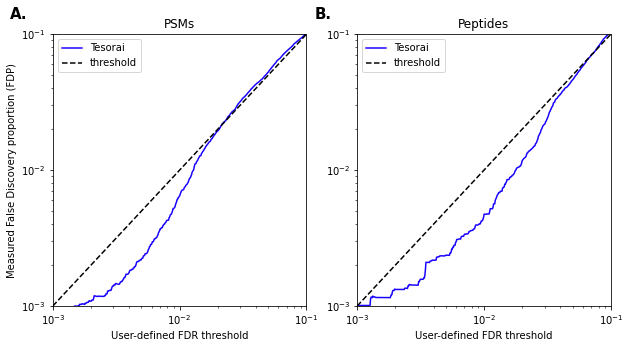

In [8]:
N = 20
_, r = plot_calibrations(tesorai_labeled, label="Tesorai", n_bootstrap=N, n_points=500)